In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from sklearn.linear_model import LinearRegression
from datetime import datetime
import time
from WindPy import w
w.start()

start='2010-01-01'
last='2021-12-11'

# 自定义函数

In [18]:
# 时间比较，返回较晚的日期
def compare_time(time1,time2):
    s_time = time.mktime(time.strptime(time1,'%Y-%m-%d'))
    e_time = time.mktime(time.strptime(time2,'%Y-%m-%d'))
    if s_time>e_time:
        time3=time1
    else:
        time3=time2
    return time3

# 导入因子数据

In [3]:
 
#导入基准数据并变成收益率序列        

baselist0=["CBA00601.CS","CBA00721.CS","CBA00861.CS","CBA04201.CS","CBA02501.CS","CBA03801.CS","000832.CSI","885009.WI"]
baseimport=w.wsd(baselist0,"close", start, last, "Period=W")
baselist1=['zong','short','long','AAA','govern','highrate','stock','huobi']
# zong#中债总财富指数
# short=w.wsd("CBA00721.CS", "close", "start", "last", "") #中债中短期(1-3)总财富指数
# long=w.wsd("CBA00861.CS", "close", "start", "last", "")  #中债长期(>10)债券指数
# AAA=w.wsd("CBA04201.CS", "close", "start", "last", "") #中债企业债 AAA 指数
# govern=w.wsd("CBA02501.CS", "close", "start", "last", "") #中债国开行债券指数
# highrate=w.wsd("CBA03801.CS", "close", "start", "last", "") #中债高收益企业债指数
# stock=w.wsd("000832.CSI", "close", "start", "last", "") #中证转债
# huobi=w.wsd("885009.WI", "close", "start", "last", "") #货币市场基金指数
dates=pd.to_datetime(baseimport.Times)
base = pd.DataFrame(baseimport.Data).T
base.index = dates.strftime("%Y-%m-%d")
base.columns = baselist1
base=base.pct_change()*100
print(base)

#导入基准久期数据 
durationlist0=["CBA00301.CS","CBA00721.CS","CBA00861.CS","CBA04201.CS","CBA02501.CS","CBA03801.CS"]
durationimport=w.wsd(durationlist0,"duration", start, last, "Period=W")
durationlist1=['zong','short','long','AAA','govern','highrate']
dates=pd.to_datetime(durationimport.Times)
duration = pd.DataFrame(durationimport.Data).T
duration.index = dates.strftime("%Y-%m-%d")
duration.columns = durationlist1

# 导入凸度因子数据
# 涨跌幅
convexlist0=['CBA02521.CS','CBA02531.CS','CBA02541.CS','CBA02561.CS']
convexlist1=['shortest','shorter','longer','longest']
convex_pct0=w.wsd(convexlist0,'close',start, last, "Period=W")
dates=pd.to_datetime(convex_pct0.Times)
convex_pct = pd.DataFrame(convex_pct0.Data).T
convex_pct.index = dates.strftime("%Y-%m-%d")
convex_pct.columns = convexlist1
convex_pct=convex_pct.pct_change()*100

# 久期
convex_dur0=w.wsd(convexlist0,'duration',start, last, "Period=W")
dates=pd.to_datetime(convex_dur0.Times)
convex_dur = pd.DataFrame(convex_dur0.Data).T
convex_dur.index = dates.strftime("%Y-%m-%d")
convex_dur.columns = convexlist1

# 凸度
convex_con0=w.wsd(convexlist0,'convexity',start, last, "Period=W")
dates=pd.to_datetime(convex_con0.Times)
convex_con = pd.DataFrame(convex_con0.Data).T
convex_con.index = dates.strftime("%Y-%m-%d")
convex_con.columns = convexlist1


ValueError: Length mismatch: Expected axis has 1 elements, new values have 8 elements

# 构造因子

In [4]:
# 构造因子
# level——zong
# slope——long and short
# credit——AAA and govern
# default——highrate and AAA
# convert——stock and zong

# 久期因子（level）——利率曲线变动的影响（beta影响）——中债国债总财富指数
level=base['zong']

# 利率曲线结构（slope）——中债中短期债券指数和中债长期债券指数——久期中性（权重动态调整）
# weightshort=duration['long']/(duration['long']+duration['short'])
# weightlong=duration['short']/(duration['short']+duration['long'])
# slope=base['short']*weightshort-base['long']*weightlong
slope=base['short']*duration['long']/duration['short']-base['long']
# # 凸度（convex）——中债国开行债券总财富（1-3，3-5，5-7，>10）——斜率中性、久期中性（权重动态调整）
convex_est_con=convex_pct['shortest']*convex_con['longest']/convex_con['shortest']-convex_pct['longest']
convex_er_con=convex_pct['shorter']*convex_con['longer']/convex_con['shorter']-convex_pct['longer']
convex_est_dur=convex_con['shortest']*convex_dur['longest']/convex_dur['shortest']-convex_con['longest']
convex_er_dur=convex_con['shorter']*convex_dur['longer']/convex_dur['shorter']-convex_con['longer']
convex=convex_est_con*convex_er_dur/convex_est_dur-convex_er_con

# slope=base['short']-base['long']
# 信用利差（credit）——中债企业债 AAA 指数和中债国开行债券指数——久期中性（权重动态调整）
# weightAAA_credit=duration['govern']/(duration['govern']-duration['AAA'])
# weightgovern=duration['AAA']/(duration['AAA']-duration['govern'])
# credit=base['AAA']*weightAAA_credit+base['govern']*weightgovern
credit=base['AAA']*duration['govern']/duration['AAA']-base['govern']
# 违约（default）——中债高收益企业债指数和中债企业债 AAA 指数——久期中性（权重动态调整）
# weightAAA_default=duration['highrate']/(duration['highrate']-duration['AAA'])
# weighthighrate=duration['AAA']/(duration['AAA']-duration['highrate'])
# default=base['highrate']*weighthighrate+base['AAA']*weightAAA_default
default=base['highrate']*duration['AAA']/duration['highrate']-base['AAA']
# 可转债因子（convertible）——中证转债和中债国债总财富指数
convert=(base['stock']-base['zong'])
# 货币因子（currency）——货币市场基金指数
currency=base['huobi']
# 画图
# level.plot(kind='line',grid=True,label='level',title='level')
# slope.plot(kind='line',grid=True,label='slope',title='slope')
# credit.plot(kind='line',grid=True,label='credit',title='credit')
# default.plot(kind='line',grid=True,label='default',title='default')
# convert.plot(kind='line',grid=True,label='convert',title='factors')

# 导出因子序列
levelSeries=pd.Series(level,index=base.index)
slopeSeries=pd.Series(slope,index=base.index)
convexSeries=pd.Series(convex,index=base.index)
creditSeries=pd.Series(credit,index=base.index)
defaultSeries=pd.Series(default,index=base.index)
convertSeries=pd.Series(convert,index=base.index)
currencySeries=pd.Series(currency,index=base.index)
factor_nav=pd.concat([levelSeries,slopeSeries,convexSeries,creditSeries,defaultSeries,convertSeries,currencySeries],axis=1)
factor_nav.columns=['level','slope','convex','credit','default','convert','currency']
print(factor_nav)

               level     slope    convex    credit   default   convert  \
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-15 -0.103136 -0.077538  0.004501  0.127038  0.167562  0.698383   
2010-01-22  0.276560  0.021243 -0.038347  0.383628  0.131272 -2.988607   
2010-01-29  0.426663 -0.173364 -0.293704 -0.013985 -0.023638 -7.478320   
2010-02-05  0.536649  0.023372 -0.001811 -0.037991  0.063686 -1.945436   
...              ...       ...       ...       ...       ...       ...   
2021-11-12 -0.114359  0.626559  0.074165  0.079167  0.158017  2.782184   
2021-11-19  0.143235  0.570583  0.083626  0.062967  0.156586  0.349410   
2021-11-26  0.394274  0.330873  0.044135  0.002515  0.066800  0.291708   
2021-12-03 -0.205495  0.410203  0.006082  0.210346  0.100335  1.905883   
2021-12-10  0.211922  0.211250  0.050546  0.048489  0.072655 -0.864164   

            currency  
2010-01-08       NaN  
2010-01-15  0.022717  
2010-01-22  0.024793  
2010-01-29  0.02944

# 生成因子收益率序列

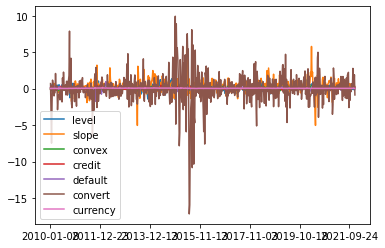

               level     slope    convex    credit   default   convert  \
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-15 -0.103136 -0.077538  0.004501  0.127038  0.167562  0.698383   
2010-01-22  0.276560  0.021243 -0.038347  0.383628  0.131272 -2.988607   
2010-01-29  0.426663 -0.173364 -0.293704 -0.013985 -0.023638 -7.478320   
2010-02-05  0.536649  0.023372 -0.001811 -0.037991  0.063686 -1.945436   
...              ...       ...       ...       ...       ...       ...   
2021-11-12 -0.114359  0.626559  0.074165  0.079167  0.158017  2.782184   
2021-11-19  0.143235  0.570583  0.083626  0.062967  0.156586  0.349410   
2021-11-26  0.394274  0.330873  0.044135  0.002515  0.066800  0.291708   
2021-12-03 -0.205495  0.410203  0.006082  0.210346  0.100335  1.905883   
2021-12-10  0.211922  0.211250  0.050546  0.048489  0.072655 -0.864164   

            currency  
2010-01-08       NaN  
2010-01-15  0.022717  
2010-01-22  0.024793  
2010-01-29  0.02944

In [5]:
factor=factor_nav
factor.columns=['level','slope','convex','credit','default','convert','currency']
factor.plot()
plt.legend()
plt.show()
writer = pd.ExcelWriter('海通七因子.xlsx')
factor.to_excel(writer, 'page_1', float_format='%.3f')		# ‘page_1’是写入excel的sheet名
writer.save()
print(factor)

# 相关性分析

In [6]:
#相关性分析
# 疑问：为什么研报里相关性那么小？
# factor0=factor.pct_change().dropna() #收益率序列的相关性分析
cormatrix=factor.corr()
print('相关性分析')
print(cormatrix)

相关性分析
             level     slope    convex    credit   default   convert  currency
level     1.000000  0.251009  0.171608 -0.192302 -0.231964 -0.123773  0.103259
slope     0.251009  1.000000  0.361326  0.118620 -0.062134  0.166192  0.190736
convex    0.171608  0.361326  1.000000  0.082370 -0.119825  0.090777  0.076788
credit   -0.192302  0.118620  0.082370  1.000000 -0.167638  0.112616  0.038287
default  -0.231964 -0.062134 -0.119825 -0.167638  1.000000  0.089226 -0.032110
convert  -0.123773  0.166192  0.090777  0.112616  0.089226  1.000000  0.069781
currency  0.103259  0.190736  0.076788  0.038287 -0.032110  0.069781  1.000000


# 读取中长期纯债基金名单与截取因子日期

In [7]:
# # 读取基金名单——之后可以放程序
io = r'C:\Users\DELL\Desktop\债基整理\中长期纯债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist.to_excel('中长期纯债基金名单.xlsx', index=False)
fund_long=pd.read_excel('中长期纯债基金名单.xlsx')
fund_long=fund_long.sort_values(by='incdate').reset_index(drop=True)
fund_long['int_date']=fund_long['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_long=fund_long[(fund_long['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得中长债基金收益率数据

In [8]:
fund_long_data=w.wsd(fund_long['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_long_data.Times)
fund_long_data.index = date.strftime("%Y-%m-%d")
fund_long_rate= pd.DataFrame(fund_long_data.Data).T
fund_long_rate.index=fund_long_data.index
fund_long_rate.drop(fund_long_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_long)):
    jijin=w.wsd(fund_long['fcode'][i],"NAV_adj",compare_time(fund_long['incdate'][i].strftime("%Y-%m-%d"),start),last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_long_rate=pd.concat([fund_long_rate,jj],axis=1)
print(fund_long_rate)
writer_long = pd.ExcelWriter('中长期债基收益率.xlsx')
fund_long_rate.to_excel(writer_long, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_long.save()


100%|██████████████████████████████████████████████████████████████████████████████| 1542/1542 [10:49<00:00,  2.38it/s]


            217003.OF  161603.OF  371020.OF  519985.OF  100058.OF  040026.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.457457   0.176056   0.197628        NaN        NaN        NaN   
2010-01-22  -0.091075  -0.378072   0.098619        NaN        NaN        NaN   
2010-01-29  -0.783956  -0.853890   0.098522        NaN        NaN        NaN   
2010-02-05   0.238883  -0.191388   0.196850        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.023866   0.091996   2.401209   0.034798   0.017122   0.000000   
2021-11-19   0.182932   0.275735   0.597873   0.104357   0.119832   0.095329   
2021-11-26   0.214354   0.274977   0.995678   0.147685   0.162435   0.161905   
2021-12-03   0.023766   0.091408   1.536110   0.000000   0.025606   0.076067   
2021-12-10   0.102962   0.091324  -0.496764   0.104094   0.110931   0.114014   

            261002.OF  110037.OF  16101

# 读取短期纯债基金名单与截取因子日期

In [9]:
io = r'C:\Users\DELL\Desktop\债基整理\短期纯债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist.to_excel('短期纯债基金名单.xlsx', index=False)
fund_short=pd.read_excel('短期纯债基金名单.xlsx')
fund_short=fund_short.sort_values(by='incdate').reset_index(drop=True)
fund_short['int_date']=fund_short['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_short=fund_short[(fund_short['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得短债基金收益率数据

In [10]:
fund_short_data=w.wsd(fund_short['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_short_data.Times)
fund_short_data.index = date.strftime("%Y-%m-%d")
fund_short_rate= pd.DataFrame(fund_short_data.Data).T
fund_short_rate.index=fund_short_data.index
fund_short_rate.drop(fund_short_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_short)):
    jijin=w.wsd(fund_short['fcode'][i],"NAV_adj",compare_time(fund_short['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_short_rate=pd.concat([fund_short_rate,jj],axis=1)
print(fund_short_rate)
writer_short = pd.ExcelWriter('短期债基收益率.xlsx')
fund_short_rate.to_excel(writer_short, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_short.save()


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [01:16<00:00,  2.31it/s]


            270043.OF  040045.OF  000084.OF  000128.OF  000503.OF  000394.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-22        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-29        NaN        NaN        NaN        NaN        NaN        NaN   
2010-02-05        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2021-11-12        0.0   0.046045   0.061819   0.033190   0.043773   0.063997   
2021-11-19        0.0   0.082842   0.077226   0.049768   0.026891   0.054820   
2021-11-26        0.0   0.073577   0.054017   0.058033   0.071691   0.073053   
2021-12-03        0.0   0.055142   0.053987   0.033143   0.036204   0.045625   
2021-12-10        0.0   0.064297   0.054037   0.041415   0.065353   0.054725   

            002301.OF  002864.OF  51919

# 读取混合一级债基名单与截取因子日期

In [11]:
io =r'C:\Users\DELL\Desktop\债基整理\混合一级债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist.to_excel('混合一级债基金名单.xlsx', index=False)
fund_first=pd.read_excel('混合一级债基金名单.xlsx')
fund_first=fund_first.sort_values(by='incdate').reset_index(drop=True)
fund_first['int_date']=fund_first['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_first=fund_first[(fund_first['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得混合一级债基金收益率数据

In [12]:
fund_first_data=w.wsd(fund_first['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_first_data.Times)
fund_first_data.index = date.strftime("%Y-%m-%d")
fund_first_rate= pd.DataFrame(fund_first_data.Data).T
fund_first_rate.index=fund_first_data.index
fund_first_rate.drop(fund_first_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_first)):
    jijin=w.wsd(fund_first['fcode'][i],"NAV_adj",compare_time(fund_first['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_first_rate=pd.concat([fund_first_rate,jj],axis=1)
print(fund_first_rate)
writer_first = pd.ExcelWriter('混合一级债基收益率.xlsx')
fund_first_rate.to_excel(writer_first, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_first.save()

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:37<00:00,  2.43it/s]


            001001.OF  090002.OF  070005.OF  160602.OF  240003.OF  100018.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.455789   0.695238   0.790514   0.172861   0.398234   0.934655   
2010-01-22  -0.272232  -0.520823  -0.941176  -0.086281  -0.279427  -0.563652   
2010-01-29  -0.454959   0.175285  -0.475059   0.000000  -0.288967  -0.696413   
2010-02-05   0.000000  -0.418003  -0.318218  -0.086356  -0.131729  -0.065237   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.838415   0.696098   0.254291   0.076570   0.464904   0.131994   
2021-11-19   0.000000   0.509369   0.162052   0.153022   0.128964   0.175760   
2021-11-26   0.226757   0.493602   0.297744   0.076394   0.189408   0.219314   
2021-12-03   0.301659   1.027833   0.298008   0.076336   0.204174   0.087534   
2021-12-10  -0.075188  -0.603223  -0.297123   0.076278  -0.083013   0.087457   

            020002.OF  320004.OF  48510

# 读取二级混合债基名单与截取因子日期

In [3]:
io =r'C:\Users\DELL\Desktop\债基整理\混合二级债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist.to_excel('混合二级债基金名单.xlsx', index=False)
fund_second=pd.read_excel('混合二级债基金名单.xlsx')
fund_second=fund_second.sort_values(by='incdate').reset_index(drop=True)
fund_second['int_date']=fund_second['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_second=fund_second[(fund_second['int_date']<20201231)] #选取一年前成立的基金


# 获得混合二级债基金收益率数据

In [7]:
fund_second_data=w.wsd(fund_second['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_second_data.Times)
fund_second_data.index = date.strftime("%Y-%m-%d")
fund_second_rate= pd.DataFrame(fund_second_data.Data).T
fund_second_rate.index=fund_second_data.index
fund_second_rate.drop(fund_second_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_second)):
    jijin=w.wsd(fund_second['fcode'][i],"NAV_adj",compare_time(fund_second['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_second_rate=pd.concat([fund_second_rate,jj],axis=1)
print(fund_second_rate)
writer_second = pd.ExcelWriter('混合二级债基收益率.xlsx')
fund_second_rate.to_excel(writer_second, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_second.save()


100%|████████████████████████████████████████████████████████████████████████████████| 344/344 [02:25<00:00,  2.36it/s]


            202101.OF  161902.OF  110007.OF  519519.OF  540001.OF  290003.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.948930   0.527634   1.179421   0.434421   0.970779   0.385654   
2010-01-22  -0.692189  -1.085313  -1.156494   0.027609  -1.675245  -1.104495   
2010-01-29  -1.213321  -0.989298  -0.668586   0.156408  -1.298830  -0.942022   
2010-02-05  -0.461672  -0.617676  -0.158923   0.238839  -0.865606  -0.500000   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.319539   1.172126   0.155554   2.164381   0.530692   0.805648   
2021-11-19   0.089341   0.103158  -0.028239   0.054790  -0.035193  -0.321331   
2021-11-26  -0.081500   0.753072   0.042370   0.310304   0.123218   0.669532   
2021-12-03   0.403946   1.148702   0.451754   1.364753   0.281294   0.188850   
2021-12-10   0.789168  -0.567828   0.470803  -0.080783   0.052595   0.213080   

            217008.OF  001011.OF  42000

# 读取货币基金名单与截取因子日期

In [8]:
io =r'C:\Users\DELL\Desktop\债基整理\货币基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist.to_excel('货币基金名单.xlsx', index=False)
fund_huobi=pd.read_excel('货币基金名单.xlsx')
fund_huobi=fund_huobi.sort_values(by='incdate').reset_index(drop=True)
fund_huobi['int_date']=fund_huobi['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_huobi=fund_huobi[(fund_huobi['int_date']<20201231)] #选取一年前成立的基金


# 获得货币基金收益率数据

In [9]:
fund_huobi_data=w.wsd(fund_huobi['fcode'][0],"NAV_adj", start, last, period='W')
date=pd.to_datetime(fund_huobi_data.Times)
fund_huobi_data.index = date.strftime("%Y-%m-%d")
fund_huobi_rate= pd.DataFrame(fund_huobi_data.Data).T
fund_huobi_rate.index=fund_huobi_data.index
fund_huobi_rate.drop(fund_huobi_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_huobi)):
    jijin=w.wsd(fund_huobi['fcode'][i],"NAV_adj",compare_time(fund_huobi['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_huobi_rate=pd.concat([fund_huobi_rate,jj],axis=1)
print(fund_huobi_rate)
writer_huobi = pd.ExcelWriter('货币基金收益率.xlsx')
fund_huobi_rate.to_excel(writer_huobi, 'page_1', float_format='%.3f')		# ‘page_1’是写入excel的sheet名
writer_huobi.save()

100%|████████████████████████████████████████████████████████████████████████████████| 339/339 [03:24<00:00,  1.66it/s]


            040003.OF  217004.OF  050003.OF  290001.OF  202301.OF  519999.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.023716   0.019244   0.023394   0.018865   0.030490   0.025414   
2010-01-22   0.026052   0.019446   0.023625   0.033404   0.033045   0.023353   
2010-01-29   0.026980   0.019570   0.023574   0.033174   0.025170   0.024499   
2010-02-05   0.028694   0.019757   0.024269   0.032771   0.021641   0.040775   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.036183   0.037904   0.037114   0.041931   0.040047   0.037314   
2021-11-19   0.056623   0.037160   0.037505   0.041556   0.044994   0.038388   
2021-11-26   0.052604   0.038271   0.037988   0.042244   0.040243   0.044042   
2021-12-03   0.033530   0.037904   0.038732   0.045032   0.040973   0.039291   
2021-12-10   0.046477   0.038966   0.038761   0.042490   0.039724   0.039847   

            003003.OF  320002.OF  15000

# 读取基金收益率与因子数据

In [3]:
fund_long=pd.read_excel('中长期纯债基金名单.xlsx')
fund_short=pd.read_excel('短期纯债基金名单.xlsx')
fund_first=pd.read_excel('混合一级债基金名单.xlsx')
fund_second=pd.read_excel('混合二级债基金名单.xlsx')
fund_huobi=pd.read_excel('货币基金名单.xlsx')

factor=pd.read_excel('海通七因子.xlsx')
factor.index=factor.iloc[:,0]
factor=factor.drop(columns='Unnamed: 0')

fund_long_rate=pd.read_excel('中长期债基收益率.xlsx')
fund_long_rate.index=fund_long_rate.iloc[:,0]
fund_long_rate=fund_long_rate.drop(columns='Unnamed: 0')

fund_short_rate=pd.read_excel('短期债基收益率.xlsx')
fund_short_rate.index=fund_short_rate.iloc[:,0]
fund_short_rate=fund_short_rate.drop(columns='Unnamed: 0')

fund_first_rate=pd.read_excel('混合一级债基收益率.xlsx')
fund_first_rate.index=fund_first_rate.iloc[:,0]
fund_first_rate=fund_first_rate.drop(columns='Unnamed: 0')

fund_second_rate=pd.read_excel('混合二级债基收益率.xlsx')
fund_second_rate.index=fund_second_rate.iloc[:,0]
fund_second_rate=fund_second_rate.drop(columns='Unnamed: 0')

fund_huobi_rate=pd.read_excel('货币基金收益率.xlsx')
fund_huobi_rate.index=fund_huobi_rate.iloc[:,0]
fund_huobi_rate=fund_huobi_rate.drop(columns='Unnamed: 0')

print(factor)
print(fund_long_rate)
print(fund_short_rate)
print(fund_first_rate)
print(fund_second_rate)
print(fund_huobi_rate)

            level  slope  convex  credit  default  convert  currency
Unnamed: 0                                                          
2010-01-08    NaN    NaN     NaN     NaN      NaN      NaN       NaN
2010-01-15 -0.103 -0.078   0.005   0.127    0.168    0.698     0.023
2010-01-22  0.277  0.021  -0.038   0.384    0.131   -2.989     0.025
2010-01-29  0.427 -0.173  -0.294  -0.014   -0.024   -7.478     0.029
2010-02-05  0.537  0.023  -0.002  -0.038    0.064   -1.945     0.028
...           ...    ...     ...     ...      ...      ...       ...
2021-11-12 -0.114  0.627   0.074   0.079    0.158    2.782     0.039
2021-11-19  0.143  0.571   0.084   0.063    0.157    0.349     0.039
2021-11-26  0.394  0.331   0.044   0.003    0.067    0.292     0.040
2021-12-03 -0.205  0.410   0.006   0.210    0.100    1.906     0.040
2021-12-10  0.212  0.211   0.051   0.048    0.073   -0.864     0.041

[612 rows x 7 columns]
            217003.OF  161603.OF  371020.OF  519985.OF  100058.OF  040026.OF  \

# 回归

In [6]:
def fund_regression(fund,fund_rate):
    fund['int_date']=fund['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
    fund=fund[(fund['int_date']<20201231)]
    R2=np.zeros(len(fund))
    COEF=np.zeros((len(fund),7))
    ALPHA=np.zeros(len(fund))
    for i in trange(len(fund)):
        y=fund_rate.iloc[:,i]
        z=pd.concat([y,factor],axis=1).dropna()
        xx=np.array(z.loc[:,'level':'currency'])
        yy=np.array(z.iloc[:,0])
        model = LinearRegression()
        model.fit(xx, yy)
        r2=model.score(xx,yy)
        coef=model.coef_
        alpha=model.intercept_
        R2[i]=r2
        COEF[i]=coef
        ALPHA[i]=alpha
    fund['R2']=R2
    fund['久期']=COEF[:,0]
    fund['凸度']=COEF[:,1]
    fund['利率曲线结构']=COEF[:,2]
    fund['信用利差']=COEF[:,3]
    fund['违约']=COEF[:,4]
    fund['可转债']=COEF[:,5]
    fund['货币']=COEF[:,6]
    fund['alpha']=ALPHA
    return fund
result_short=fund_regression(fund_short,fund_short_rate)
result_short.to_excel('七因子短期债基解释度.xlsx',index=False)
result_long=fund_regression(fund_long,fund_long_rate)
result_long.to_excel('七因子中长期债基解释度.xlsx',index=False)
result_first=fund_regression(fund_first,fund_first_rate)
result_first.to_excel('七因子混合一级债基解释度.xlsx',index=False)
result_second=fund_regression(fund_second,fund_second_rate)
result_second.to_excel('七因子混合二级债基解释度.xlsx',index=False)
result_huobi=fund_regression(fund_huobi,fund_huobi_rate)
result_huobi.to_excel('七因子货币基金解释度.xlsx',index=False)

100%|███████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 205.37it/s]
<ipython-input-6-de528256aded>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund['R2']=R2
<ipython-input-6-de528256aded>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund['久期']=COEF[:,0]
<ipython-input-6-de528256aded>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

100%|███████████████████████████████████████████████████████████████████████████████| 344/344 [00:01<00:00, 223.94it/s]
<ipython-input-6-de528256aded>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund['R2']=R2
<ipython-input-6-de528256aded>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund['久期']=COEF[:,0]
<ipython-input-6-de528256aded>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav


七因子中长债债基解R2与alpha

七因子短债债基R2与alpha

七因子混合一级债基R2与alpha

七因子混合二级债基R2与alpha

七因子混合二级债基R2与alpha


<ipython-input-7-71a7d5a9b192>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(224)


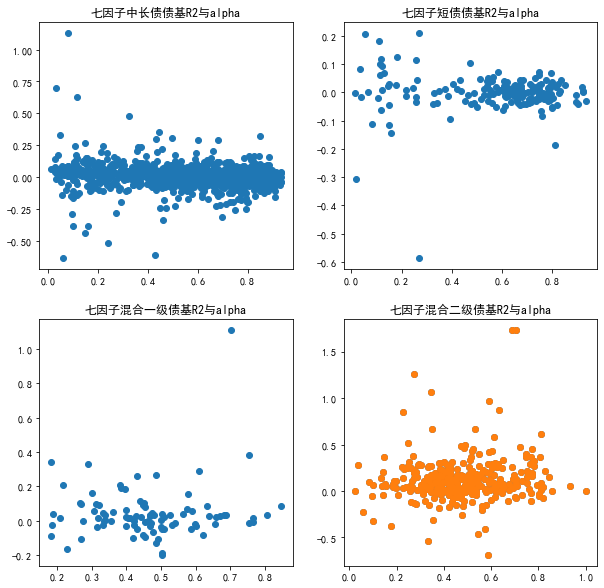


七因子中长期债基解久期与利率曲线结构

七因子短期债基久期与利率曲线结构

七因子混合一级债基久期与利率曲线结构

七因子混合二级债基久期与利率曲线结构


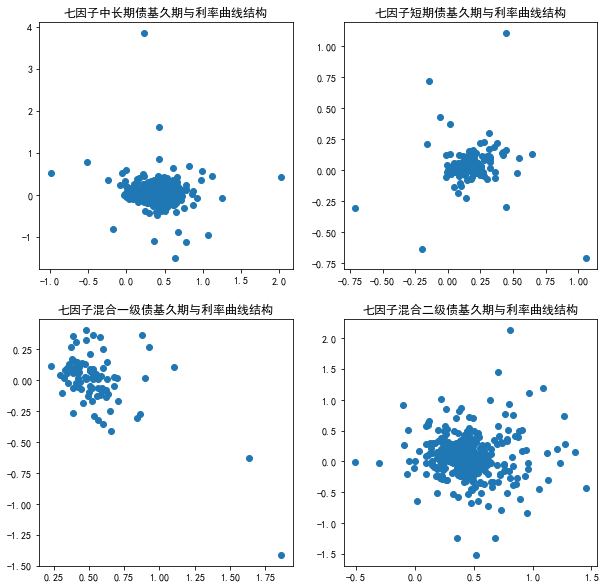

int_date    2.018091e+07
R2          6.622846e-01
久期          3.267913e-01
凸度          6.107136e-02
利率曲线结构      3.293837e-02
信用利差        1.297231e-01
违约          1.307743e-02
可转债         7.415072e-04
货币          2.356730e-01
alpha       6.444999e-03
dtype: float64
int_date    2.019062e+07
R2          6.485033e-01
久期          1.329905e-01
凸度          3.491629e-02
利率曲线结构      2.419594e-02
信用利差        1.172358e-01
违约          8.185397e-03
可转债         1.207083e-03
货币          6.249732e-01
alpha       3.797112e-04
dtype: float64
int_date    2.011071e+07
R2          4.545581e-01
久期          5.078092e-01
凸度          4.456776e-02
利率曲线结构      2.791584e-02
信用利差        4.604188e-01
违约          2.018979e-01
可转债         1.139858e-01
货币          1.800101e-01
alpha       1.946537e-02
dtype: float64
int_date    2.016082e+07
R2          4.706217e-01
久期          4.226146e-01
凸度          1.514039e-02
利率曲线结构      5.052196e-02
信用利差        3.184390e-01
违约         -5.122852e-02
可转债         2.305605e-01
货币   

<ipython-input-7-71a7d5a9b192>:78: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_long.median())
<ipython-input-7-71a7d5a9b192>:79: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_short.median())
<ipython-input-7-71a7d5a9b192>:80: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_first.median())
<ipython-input-7-71a7d5a9b192>:81: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_second.median())
<ipython-input-7-71a7d5a9b192>:82: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in

In [7]:
# 结果分析
# 结果分析
# 图1 解释度与超额收益
plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

result_long=pd.read_excel('七因子中长期债基解释度.xlsx')
plt.subplot(221)
plt.scatter(result_long['R2'],result_long['alpha'])
plt.title('七因子中长债债基R2与alpha')
print('\n七因子中长债债基解R2与alpha')


result_short=pd.read_excel('七因子短期债基解释度.xlsx')
plt.subplot(222)
plt.scatter(result_short['R2'],result_short['alpha'])
plt.title('七因子短债债基R2与alpha')
print('\n七因子短债债基R2与alpha')


result_first=pd.read_excel('七因子混合一级债基解释度.xlsx')
plt.subplot(223)
plt.scatter(result_first['R2'],result_first['alpha'])
plt.title('七因子混合一级债基R2与alpha')
print('\n七因子混合一级债基R2与alpha')


result_second=pd.read_excel(r'七因子混合二级债基解释度.xlsx')
plt.subplot(224)
plt.scatter(result_second['R2'],result_second['alpha'])
plt.title('七因子混合二级债基R2与alpha')
print('\n七因子混合二级债基R2与alpha')

result_second=pd.read_excel(r'七因子混合二级债基解释度.xlsx')
plt.subplot(224)
plt.scatter(result_second['R2'],result_second['alpha'])
plt.title('七因子混合二级债基R2与alpha')
print('\n七因子混合二级债基R2与alpha')
plt.show()

# 久期因子与斜率因子
plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

result_long=pd.read_excel('七因子中长期债基解释度.xlsx')
plt.subplot(221)
plt.scatter(result_long['久期'],result_long['利率曲线结构'])
plt.title('七因子中长期债基久期与利率曲线结构')
print('\n七因子中长期债基解久期与利率曲线结构')
# print(result_long.median())

result_short=pd.read_excel('七因子短期债基解释度.xlsx')
plt.subplot(222)
plt.scatter(result_short['久期'],result_short['利率曲线结构'])
plt.title('七因子短期债基久期与利率曲线结构')
print('\n七因子短期债基久期与利率曲线结构')
# print(result_short.median())

result_first=pd.read_excel('七因子混合一级债基解释度.xlsx')
plt.subplot(223)
plt.scatter(result_first['久期'],result_first['利率曲线结构'])
plt.title('七因子混合一级债基久期与利率曲线结构')
print('\n七因子混合一级债基久期与利率曲线结构')
# print(result_first.median())

result_second=pd.read_excel(r'七因子混合二级债基解释度.xlsx')
plt.subplot(224)
plt.scatter(result_second['久期'],result_second['利率曲线结构'])
plt.title('七因子混合二级债基久期与利率曲线结构')
print('\n七因子混合二级债基久期与利率曲线结构')
# print(result_second.median())
plt.show()

result_huobi=pd.read_excel(r'七因子货币基金解释度.xlsx')
# 中位数
print(result_long.median())
print(result_short.median())
print(result_first.median())
print(result_second.median())
print(result_huobi.median())

In [19]:
time1=[datetime.strftime(x,'%F') for x in pd.date_range('2014-01-01','2021-9-30',freq='Q')]
time1.append(last)
time=pd.Series(time1).str.replace(r'-','').astype('int')
time0=(np.array(time)-10000).tolist()
time3=pd.Series(time1).shift(-1).dropna().tolist()
tim3=time3.append('2021-12-31')
print(time3)
# time3=['2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31','2020-12-31','2021-12-11','2021-12-31']
print(time1)

['2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-11', '2021-12-31']
['2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-11']


In [20]:
def fund_huice(fund,fund_rate):
    fund['int_date']=fund['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
    fund=fund[(fund['int_date']<20201231)]
    fund_year=fund.copy()
    R2=np.zeros(len(fund_year))
    COEF=np.full([len(fund_year),7],np.nan)
    ALPHA=np.zeros(len(fund_year))
    fund_slice=pd.Series([],dtype=pd.StringDtype())#截取基金名单
    fund_rating=fund_rate.iloc[:,0:len(fund_slice)]
    fund_invest=pd.Series([],dtype=pd.StringDtype())
    annuallist=pd.Series([],dtype=pd.StringDtype())
    shouyi=pd.Series([],dtype=pd.StringDtype())
    yinzi_ave=pd.DataFrame([],dtype=pd.StringDtype())
    baolu=pd.DataFrame([],dtype=pd.StringDtype())
    #选取一年前成立的基金
    """想法就是说比如：样本为2013.12.31前（一年前成立）成立的基金，需要回归2014.12.31-2015.12.31年间的债基收益率，
    然后选出当年的alpha前五，在2015.12.31-2016.12.31投入。
    那么应该是三个时间序列。成立时间序列，回归时间序列，投入时间序列
    先写回归时间序列time1：time1=[datetime.strftime(x,'%F') for x in pd.date_range('2014-01-01',last,freq='Q')]QWMY
    然后成立时间序列time0：time=pd.Series(time1).str.replace(r'-','').astype('int')；
    time0=(np.array(time)-601).tolist()
    最后投入时间序列：time3=time1后移一期。
    以年为例子，投入时间序列是2015.12.31-2016.12.31,2016.12.31-2017.12.31,2017.12.31-2018.12.31,2018.12.31-2019.12.31,2019.12.31-2020.12.31,2020.12.31-2021.12.11
                那么回归序列是2014.12.31-2015.12.31,2015.12.31-2016.12.31,2016.12.31-2017.12.31,2017.12.31-2018.12.31,2018.12.31-2019.12.31,2019.12.31-2020.12.31
                呢么成立序列是2013.12.31-2014.12.31,2014.12.31-2015.12.31,2015.12.31-2016.12.31,2016.12.31-2017.12.31,2017.12.31-2018.12.31,2018.12.12-2019.12.31
                time3=[2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-11,2021-12-31]
                time1=[2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31]
                time0=[2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31] 
                但是次数是只到len(time1)-1"""
    for h in trange(len(time1)-1):
        fund_slice=fund_year[(fund_year['int_date']<time0[h])] #截取基金名单——样本为当期一年前成立的基金
        fund_rating=fund_rate.iloc[:,0:len(fund_slice)] #获取对应基金名单的基金数据
        ALPHA=np.zeros(len(fund_slice)) #alpha初始化
        for i in range(len(fund_slice)):
            y=fund_rating.loc[time1[h]:time1[h+1],fund_slice['fcode'].iloc[i]]  #截取需要回归的收益率序列
            z=pd.concat([y,factor],axis=1).dropna()
            xx=np.array(z.loc[:,'level':'currency'])
            yy=np.array(z.iloc[:,0])
            model = LinearRegression()
            model.fit(xx, yy)
            r2=model.score(xx,yy)
            coef=model.coef_
            alpha=model.intercept_
            R2[i]=r2
            COEF[i]=coef
            ALPHA[i]=alpha
            
        fund_slice=fund_slice.copy()
        fund_slice['alpha']=ALPHA
        fund_rank=fund_slice.sort_values(by='alpha',ascending=False) #alpha排名
        #投资基金名单
        fund_toinvest=fund_rank.reset_index(drop=True).loc[0:4,:] #前五
        fund_list=fund_toinvest['fcode'].tolist()
        annuallist[h]=fund_list #历年投入名单
        #因子暴露均值
        COEF_mat=pd.DataFrame(COEF).dropna()
        COEF_ave=COEF_mat.median()
        yinzi_ave=yinzi_ave.append([COEF_ave.values])
        #各基金的因子暴露
        timeline=pd.Series(np.full(len(fund_year),time1[h]))
        yinzi0=fund_year.copy()
        COEF_df=pd.DataFrame(COEF)
        COEF_df.columns=['level','slope','convex','credit','default','convert','currency']
#         print(COEF_df)
        yinzi=pd.concat([yinzi0,COEF_df,timeline],axis=1)
        baolu=baolu.append(yinzi)
        
        for j in range(len(fund_list)):
            fund_inv=fund_rating.loc[time3[h]:time3[h+1],fund_list[j]] #投入业绩回报，也就是投入序列
            fund_invest=pd.concat([fund_invest,fund_inv],axis=1)
        shouyi=pd.Series(fund_invest.mean(axis=1))
    yinzi_ave.index=pd.to_datetime(time1[:len(time1)-1]) #历年因子暴露
    yinzi_ave.columns=['level','slope','convex','credit','default','convert','currency']
    annuallist.index=pd.to_datetime(time3[:len(time3)-1]) #历年投入名单
    baolu #各基金历年因子暴露
    return shouyi,annuallist,yinzi_ave,baolu

In [21]:
huice_short,annuallist_short,yinzi_short,baolu_short=fund_huice(fund_short,fund_short_rate)
huice_short.to_excel('七因子短期债基回测.xlsx',index=True)
yinzi_short.to_excel('七因子短期债基因子暴露.xlsx',index=True)
huice_long,annuallist_long,yinzi_long,baolu_long=fund_huice(fund_long,fund_long_rate)
huice_long.to_excel('七因子中长期债基回测.xlsx',index=True)
yinzi_long.to_excel('七因子中长期债基因子暴露.xlsx',index=True)
huice_first,annuallist_first,yinzi_first,baolu_first=fund_huice(fund_first,fund_first_rate)
huice_first.to_excel('七因子混合一级债基回测.xlsx',index=True)
yinzi_first.to_excel('七因子混合一级债基因子暴露.xlsx',index=True)
huice_second,annuallist_second,yinzi_second,baolu_second=fund_huice(fund_second,fund_second_rate)
huice_second.to_excel('七因子混合二级债基回测.xlsx',index=True)
yinzi_second.to_excel('七因子混合二级债基因子暴露.xlsx',index=True)
huice_huobi,annuallist_huobi,yinzi_huobi,baolu_huobi=fund_huice(fund_huobi,fund_huobi_rate)
huice_huobi.to_excel('七因子货币基金回测.xlsx',index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:31<00:00,  1.01s/it]


In [15]:
from empyrical import (
    cum_returns,
    annual_return,
    annual_volatility,
    downside_risk,
    max_drawdown,
    sharpe_ratio,
    sortino_ratio,
    calmar_ratio,
)
def huicezhibiao(returns):
    returns=returns/100
    print('累计收益：',cum_returns(returns)[-1])
    print('最大回撤：',max_drawdown(returns))
    print('年化收益：',annual_return(returns,period='weekly'))
    print('年化波动率：',annual_volatility(returns, period='weekly'))
    print('卡玛比率：',calmar_ratio(returns))
    print('夏普比率：',sharpe_ratio(returns=returns))
    return

In [16]:
print('七因子短期债基回测')
huicezhibiao(huice_short)
print('\n七因子中长期债基回测')
huicezhibiao(huice_long)
print('\n七因子混合一级债基回测')
huicezhibiao(huice_first)
print('\n七因子混合二级债基回测')
huicezhibiao(huice_second)
print('\n七因子货币基金回测')
huicezhibiao(huice_huobi)


七因子短期债基回测
累计收益： 0.38643370428174406
最大回撤： -0.015263295064382567
年化收益： 0.04535951157813001
年化波动率： 0.015259258073540465
卡玛比率： 15.713286200048119
夏普比率： 6.419246035763079

七因子中长期债基回测
累计收益： 0.5268770082332315
最大回撤： -0.05286749589784833
年化收益： 0.05914426707043341
年化波动率： 0.03112599845912302
卡玛比率： 6.073713043999051
夏普比率： 4.100320482832128

七因子混合一级债基回测
累计收益： 1.146036034980662
最大回撤： -0.05399189560528739
年化收益： 0.10924233096940306
年化波动率： 0.05792297067293084
卡玛比率： 12.08962688112035
夏普比率： 4.007720112058281

七因子混合二级债基回测
累计收益： 0.9021350545525946
最大回撤： -0.33311330849034865
年化收益： 0.09122087044377714
年化波动率： 0.11896142124090751
卡玛比率： 1.5808998510309775
夏普比率： 1.7480757051506066

七因子货币基金回测
累计收益： 0.24036471199425669
最大回撤： 0.0
年化收益： 0.029677503461258636
年化波动率： 0.0013766172287498796
卡玛比率： nan
夏普比率： 46.78243533852782


In [24]:
# 导入对应债基指数
basementlist0=["CBA02501.CS","CBA02511.CS","CBA02521.CS","CBA02531.CS","CBA02541.CS","CBA02551.CS","CBA02561.CS"]
basementimport=w.wsd(basementlist0,"pct_chg", start, last, "Period=W")
basementlist1=['zong','<1','1-3','3-5','5-7','7-10','>10']
dates=pd.to_datetime(basementimport.Times)
basement= pd.DataFrame(basementimport.Data).T
basement.index = dates.strftime("%Y-%m-%d")
basement.columns = basementlist1


ValueError: Length mismatch: Expected axis has 1 elements, new values have 7 elements